# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [178]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [179]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [180]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
from IPython.display import display
display(azdias.head(n=1))
display(feat_info.head(n=2))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [181]:
print('azidas data shape: {},\nfeatures info. shape {}'.format(azdias.shape, feat_info.shape))

azidas data shape: (891221, 85),
features info. shape (85, 4)


In [182]:
# Checking for missing values.
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [183]:
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

**Note:** We can see that there are a lot of features/attributes have missing values. 

In [184]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [185]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.8+ KB


In [186]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEU_2015,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [187]:
display(feat_info.iloc[:, [0,3]])

,attribute,missing_or_unknown
0,AGER_TYP,"[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]"
2,ANREDE_KZ,"[-1,0]"
3,CJT_GESAMTTYP,[0]
4,FINANZ_MINIMALIST,[-1]
5,FINANZ_SPARER,[-1]
6,FINANZ_VORSORGER,[-1]
7,FINANZ_ANLEGER,[-1]
8,FINANZ_UNAUFFAELLIGER,[-1]
9,FINANZ_HAUSBAUER,[-1]


In [188]:
# We can see that for each attirbute indications for missing values differ!, 
# and we need to address these Differences respectively for each feature/attribute.
# it will be easier to define a loop to iterate and extract the related indicator and then to be used in replacing it with 'Nan'
# in the dataset.
# also stored as object which require recasting it, to match the data type of azidas data set. 

In [189]:
# Identify missing or unknown data values and convert them to NaNs.

# before we start preprocessing the data, we should make a copy of it. to compare later.

azdias_copy = azdias.copy()

In [190]:
for i in range(len(feat_info)):
    # get the indicators of [missing values] to be replaced with to np.nan
    mis_unk = feat_info.loc[i, 'missing_or_unknown']
    
    # get column names 
    feature_attr = feat_info.loc[i, 'attribute']
    target_attr = azdias_copy.columns[i]
    
    
    # we should check attributes match, [we are on the same attr.]
    assert feature_attr == target_attr 
    
    # convert the object [mis_unk] of type (string: object) to type np.array 
    to_replace = mis_unk.strip('[]')
    to_replace = to_replace.split(',')
    to_replace = np.array(to_replace)
    
    
    # get the target type to convert mis_unk to its matching type.
    target_type = azdias_copy[target_attr].dtypes
    # convert to tagert type (e.g stirng to float, string to int)
#     print(to_replace)
#     print(target_type)
    if len(to_replace[0]) >= 1: # to handle empty strings ( there is definitely a better way )
        to_replace = to_replace.astype(target_type)
#     print(to_replace)
    
    # replace the indicators with np.nan  
    azdias_copy[target_attr].replace(to_replace, np.nan, inplace=True)

In [191]:
print('Modified copy:\n',azdias_copy.isna().sum()[:7])

print('\nOriginal data:\n',azdias.isna().sum()[:7])

Modified copy:
 AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
dtype: int64

Original data:
 AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
FINANZ_SPARER              0
FINANZ_VORSORGER           0
dtype: int64


**We can clearly see there is a lot of missing values and much difference between the copies.**
AGER_TYP for instance

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

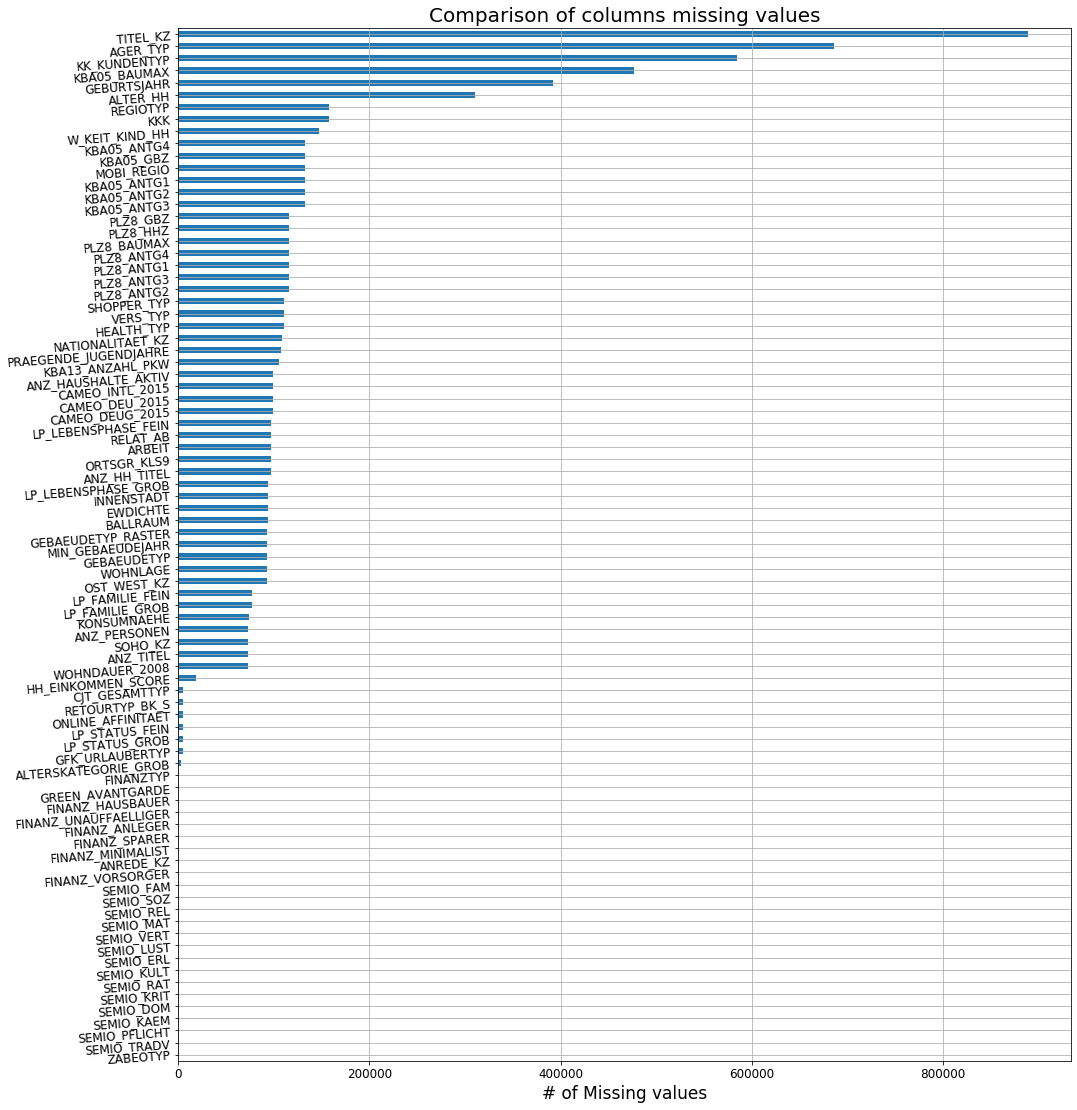

In [192]:
fig, ax = plt.subplots(figsize=(16, 19))

azdias_copy.isna().sum().sort_values().plot(kind='barh',rot=4, grid=True, fontsize=12)
# ax.grid(zorder=0)
plt.xlabel('# of Missing values', fontsize=17)
plt.title('Comparison of columns missing values', fontsize=20)

plt.show()

In [193]:
# Investigate patterns in the amount of missing data in each column.
azdias_copy.isna().sum().sort_values(ascending=False)[:7]

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
REGIOTYP        158064
dtype: int64

In [194]:
# proportion of missing values of top 6 observed outliers to the total observations + 1 for comparison which is the 7th element
azdias_copy.isna().sum().sort_values(ascending=False)[:7] / azdias_copy.shape[0]

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
REGIOTYP        0.177357
dtype: float64

We can see that [TITEL_KZ] has 99% of it's data missing we could justify removing it, as it has few data to impute (median or mean) that could replace these missing values. or any other imputation out of it. such as mode. 
we can safely say the same thing to [ AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR].

as for [ AGEBURTSJAHR, ALTER_HH, REGIOTYP ] their share of missing values is far less than **50%** which should contain helpful information that would help in building our model, and also imputing for the missing values. 

In [195]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']

azdias_copy.drop(drop, inplace=True, axis=1)
azdias_copy.shape

(891221, 80)

In [196]:
# Checking if element in drop column list is in azidas.. columns list (if everything is correct it should return false.)
any(map(lambda element: element in drop, azdias_copy.columns))

False

In [197]:
# Original, Unmodified dataset.
azdias.isna().sum().sort_values(ascending=False)[:7] / azdias_copy.shape[0]

KK_KUNDENTYP    0.655967
KBA05_ANTG1     0.149597
KBA05_ANTG2     0.149597
KBA05_ANTG3     0.149597
KBA05_ANTG4     0.149597
KBA05_BAUMAX    0.149597
KBA05_GBZ       0.149597
dtype: float64

In [198]:
# TITEL proportion of missing values in the original dataset is significaly lower than the modified type in which
# where we replaced missing indicators.
print(azdias[drop[0]].isna().sum() / len(azdias_copy))
# AGER_TYP 0.769554 proportion of missing values in the modifierd dataset, however in the original dataset 
# there is none. it has little information to offer.
print(azdias[drop[1]].isna().sum() / len(azdias_copy))

0.08247000463409188
0.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

- As shown in the plot above there happened to be 6 outlier that stand out from other columns in terms of number of missing values, however i only removed 4 of them, the justification is that these four columns have the highest proportion of missing values which is Significantly over 50%, these columns/attributes are **['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX, GEBURTSJAHR,]**
- The remaining 2 i believe we still can impute information out of these attributes as it has only less than half of it data missing. Which is **[
ALTER_HH]**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [199]:
# How much data is missing in each row of the dataset?
rows_missing = azdias_copy.isna().sum(axis=1) 

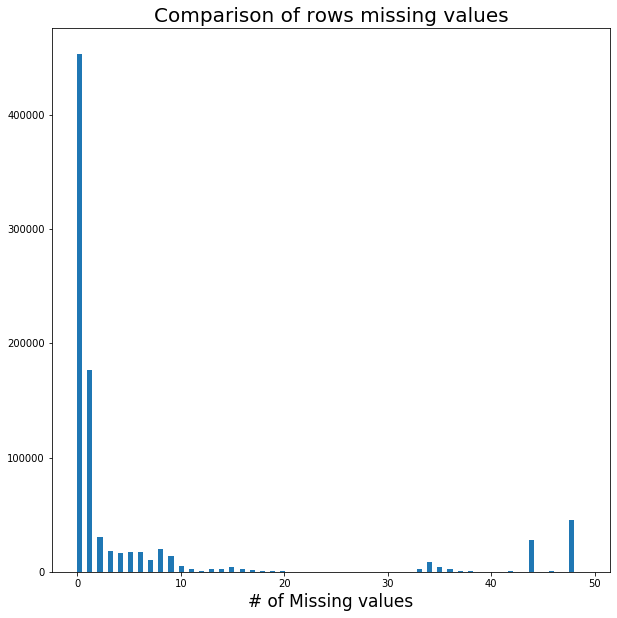

In [200]:
fig, ax = plt.subplots(figsize=(10, 10))

rows_mis = azdias_copy.isna().sum(axis=1)
plt.hist(rows_mis, bins=100)
plt.xlabel('# of Missing values', fontsize=17)
plt.title('Comparison of rows missing values', fontsize=20)
plt.show()

In [201]:
print('Max Missing: {}\nMin Missing {},'.format(rows_missing.max(), rows_missing.min()))

Max Missing: 49
Min Missing 0,


In [202]:
threshold = 12
(rows_missing > threshold).sum()

109455

In [203]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_copy_sub = azdias_copy[rows_missing > threshold]
# indices of data obove the threshold
# indices = azdias_copy_sub.index

In [204]:
azdias_copy.drop(azdias_copy[rows_missing > threshold].index, axis=0, inplace=True)

In [205]:
print(azdias_copy.shape)
print(azdias_copy_sub.shape)
assert azdias_copy.shape[0] + azdias_copy_sub.shape[0] == len(azdias)

(781766, 80)
(109455, 80)


In [206]:
# it should'nt have more than 12 missing per row. Now
azdias_copy.isna().sum(axis=1).sort_values(ascending=False)[:7]

67073     12
188512    12
348404    12
476343    12
450504    12
281865    12
413703    12
dtype: int64

In [207]:
azdias_copy_sub.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
# we can obtain columns that have few or non missing values from previous steps [in 1.1.2 step]
columns_to_compare = azdias_copy.isna().sum().sort_values(ascending=True)[:7] 

In [209]:
col_name = columns_to_compare.index
col_name

Index(['ZABEOTYP', 'ANZ_TITEL', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT'],
      dtype='object')

In [210]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare(to_compare):
    if isinstance(to_compare, str): # handle unwanted inputes (inforce single string column)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        if azdias_copy[to_compare].isna().sum() > 0:
            azdias_copy[to_compare].fillna('M', inplace=True)
        if azdias_copy_sub[to_compare].isna().sum() > 0:
            azdias_copy_sub[to_compare].fillna('M', inplace=True)
        
        
        ax1 = sns.countplot(x=to_compare, data=azdias_copy_sub, ax=ax1, palette='Set1')
        ax2 = sns.countplot(x=to_compare, data=azdias_copy, ax=ax2, palette='Set1')
        
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50)
        
        ax1.set_title('Above the threshold')
        ax2.set_title('Few or no missing values')

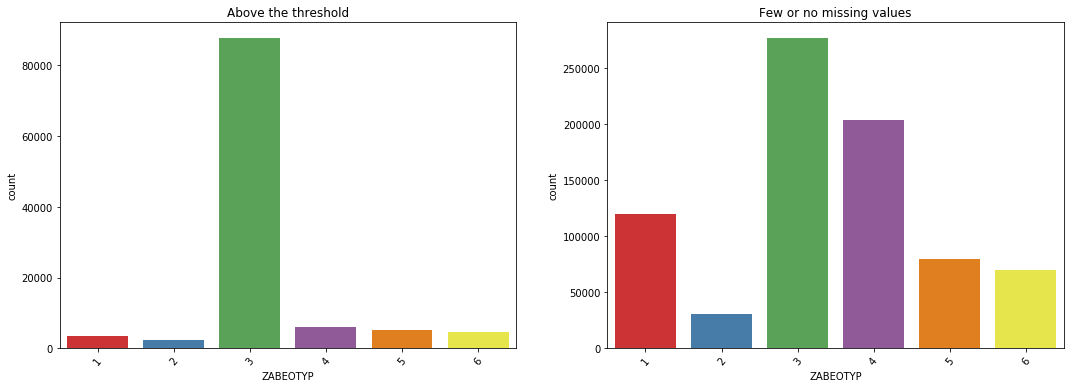

In [211]:
# Comparing for ZABEOTYP
compare(col_name[0])

/Users/yasir/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


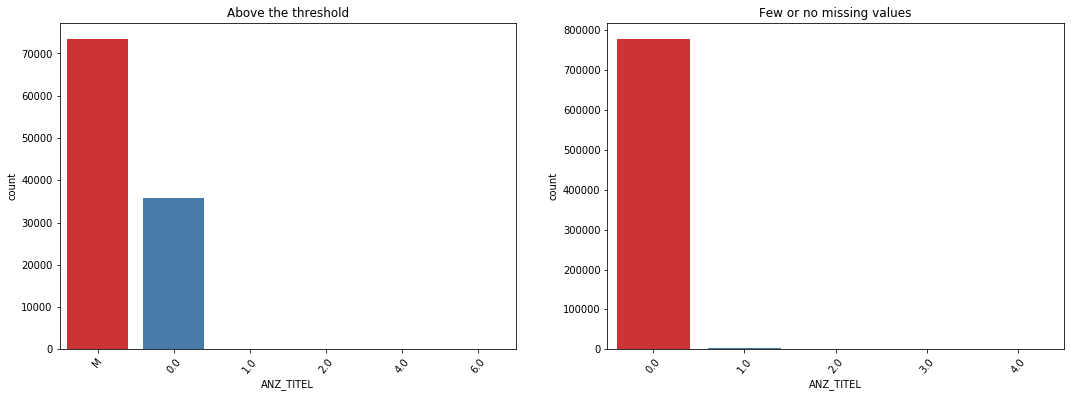

In [212]:
# Comparing for ANZ_TITEL
compare(col_name[1])

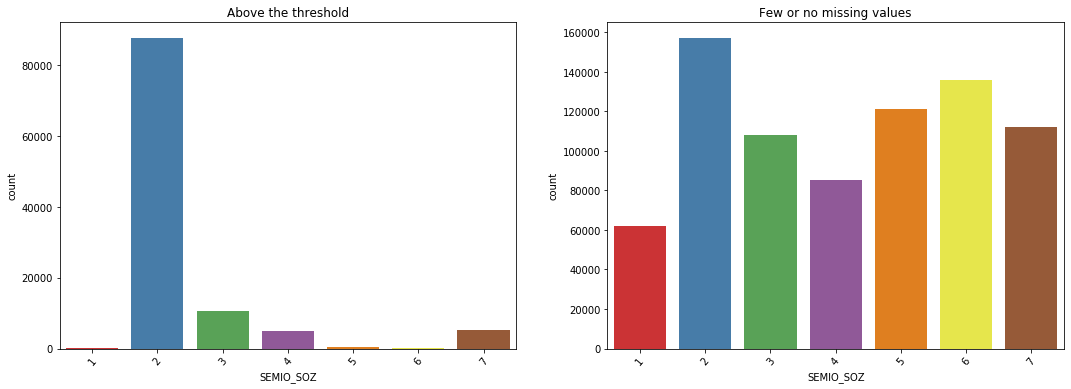

In [213]:
# Comparing for SEMIO_SOZ
compare(col_name[2])

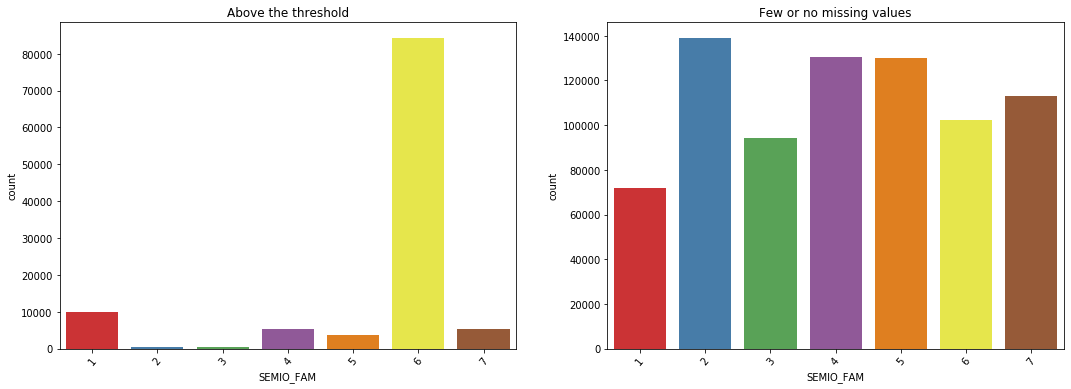

In [214]:
# Comparing for SEMIO_FAM
compare(col_name[3])

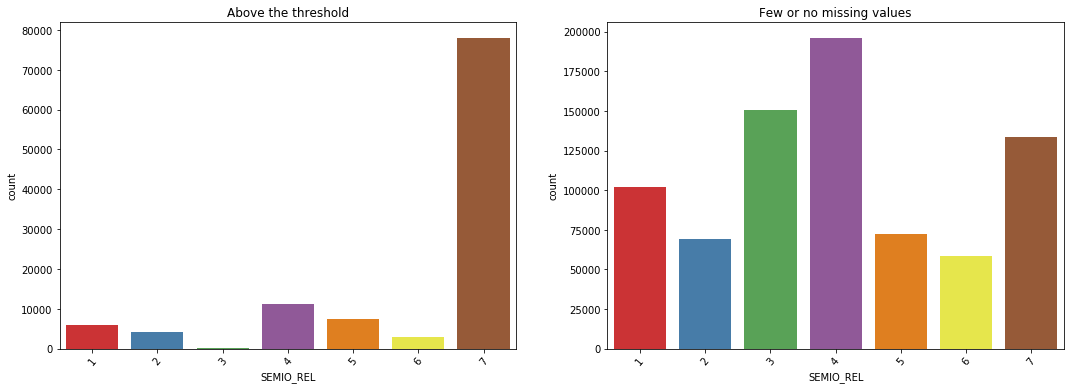

In [215]:
# Comparing for SEMIO_FAM
compare(col_name[4])

#### Discussion 1.1.3: Assess Missing Data in Each Row
- We can notice that max number of missing values that some rows contained are 50, but there also majority of rows had 0 missing values.

- for column [ZABEOTYP] we can safely remove it, as it has the same distribution in above the threshold of missing values and non-missing or few missing values. the only difference is the number of observations is less so it may seem diffrent but it has the same distribution.
the same can apply to [SEMIO_SOZ, SEMIO_REL, ]

- [SEMIO_FAM] however can see that the distribution is heavily focused on '6' which could hold useful information about it. also their distrubiton are different.
- as for [ANZ_TITEL] we can see that it suffer from missing values however the it has more information than few or non-missing values on `0.0` , so we shouldn't easily remove it. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [217]:
feat_info.iloc[:10,[0,2]]

,attribute,type
0,AGER_TYP,categorical
1,ALTERSKATEGORIE_GROB,ordinal
2,ANREDE_KZ,categorical
3,CJT_GESAMTTYP,categorical
4,FINANZ_MINIMALIST,ordinal
5,FINANZ_SPARER,ordinal
6,FINANZ_VORSORGER,ordinal
7,FINANZ_ANLEGER,ordinal
8,FINANZ_UNAUFFAELLIGER,ordinal
9,FINANZ_HAUSBAUER,ordinal


In [218]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

**There are 21 categorical types that needs to be processed.**
also miexed!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [219]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_attr = feat_info[feat_info.type == 'categorical']
for i in cat_attr.attribute:
    if i in azdias_copy.columns: # (handle error) : check if it not one of already removed columns
        print(azdias_copy.loc[:,i].value_counts())

2    407546
1    374220
Name: ANREDE_KZ, dtype: int64
4.0    193830
3.0    143873
2.0    139873
5.0    109503
6.0     99140
1.0     91517
Name: CJT_GESAMTTYP, dtype: int64
6    287341
1    193019
5    104760
2    102592
4     55165
3     38889
Name: FINANZTYP, dtype: int64
12.0    125815
10.0    101459
8.0      81922
11.0     73991
5.0      69948
4.0      60185
9.0      55817
3.0      52961
1.0      50189
7.0      40105
2.0      39792
6.0      25552
Name: GFK_URLAUBERTYP, dtype: int64
0    609789
1    171977
Name: GREEN_AVANTGARDE, dtype: int64
1.0     395716
10.0    127317
2.0      96262
11.0     48254
8.0      21352
7.0      18723
4.0      11265
5.0      10981
9.0      10294
6.0       7777
3.0       4403
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395716
5.0    185865
2.0     96262
4.0     47852
3.0     26649
Name: LP_FAMILIE_GROB, dtype: int64
1.0     204945
9.0     131505
2.0     110115
10.0    109467
4.0      73389
3.0      68481
6.0      28265
5.0      26427
8.0      16092
7.0    

we can see that [ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, OST_WEST_KZ, VERS_TYP ] are binary categorical among them - so we will leave it unchanged. However `GREEN_AVANTGARDE` and `SOHO_KZ` is correctly represented as [0, 1], we will need to fix that for the rest.
`OST_WEST_KZ`: from 'W' to 0, and 'O' to 1.
`VERS_TYP`: from '2' into 0, and 1 into 1.
`ANREDE_KZ` from '2' into 0, and 1 into 1.
the rest we need to create dummy variables (multi-encoding).

In [220]:
multi_enc = []
binary_enc = []
for column in cat_attr.attribute:
    if column in azdias_copy.columns: # to check if it not one of already removed columns
        if azdias_copy[column].nunique() > 2:
            multi_enc.append(column)
        else: 
            binary_enc.append(column)

In [221]:
display(multi_enc)
display(binary_enc)

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [222]:
# As stated above we need to addres misrepresntation of [ANREDE_KZ, OST_WEST_KZ, VERS_TYP]
azdias_copy['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

azdias_copy['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)

azdias_copy['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)


In [223]:
# categorical = cat_attr.attribute.reset_index(drop=True)
# categorical

In [224]:
# cat_lis = categorical.tolist()
# wanted_list = ['AGER_TYP', 'KK_KUNDENTYP', 'TITEL_KZ', 'ANREDE_KZ']
# indices = [ idx for idx, i in enumerate(cat_lis) if i in wanted_list ]
# indices

In [225]:
# categorical.drop(indices, inplace=True) # drop [ANREDE_KZ]  -- That we drop at previous step [AGER_TYP' 'TITEL_KZ' 'KK_KUNDENTYP]
# categorical

In [226]:
multi_enc

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [227]:
azdias_copy[multi_enc].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [228]:
# Re-encode categorical variable(s) to be kept in the analysis.
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(categorical_features=categorical)
# cat_encoded = encoder.fit_transform(azdias_copy)

azdias_copy = pd.get_dummies(azdias_copy, columns=multi_enc)

In [229]:
# azdias_copy.drop(categorical, axis=1, inplace=True)
# azdias_copy = pd.concat([azdias_copy, dummy_azdias])
# azdias_copy.drop(multi_enc, axis=1, inplace=True)

In [230]:
azdias_copy.isna().sum()

ALTERSKATEGORIE_GROB       2676
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                35015
LP_LEBENSPHASE_FEIN       47248
LP_LEBENSPHASE_GROB       44558
PRAEGENDE_JUGENDJAHRE     26631
RETOURTYP_BK_S             4030
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                  35015
ALTER_HH                 225664
ANZ_PERS

In [231]:
# dummy_azdias.isna().sum()

#### Discussion 1.2.1: Re-Encode Categorical Features

from all the categorical attributes there were couple of attribute that had a binary encoding so i remove it as it didnt required any further encoding other than represent some of them which were described above. so i am left with categorical attributes that aren’t binary which required the usage `of pandas.get_dummies` 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [232]:
mix_attr = feat_info[feat_info.type == 'mixed']
filter =(mix_attr["attribute"]=="PRAEGENDE_JUGENDJAHRE") | (mix_attr["attribute"]=="CAMEO_INTL_2015")
mix_attr = mix_attr[filter]
mix_attr.reset_index(drop=True, inplace=True)
mix_attr

,attribute,information_level,type,missing_or_unknown
0,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
1,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [233]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
attr = mix_attr.attribute[0]
display(azdias_copy[attr].value_counts())
# For movement attribute
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
# For region attribute
east = [7,12,13]
west = [6,10,11]
east_west = [1,2,3,4,5,8,9,14,15]

14.0    178757
8.0     139001
10.0     84045
5.0      83782
3.0      53181
15.0     41117
11.0     34715
9.0      33255
6.0      25546
12.0     24066
4.0      20356
1.0      20326
2.0       7450
13.0      5565
7.0       3973
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [234]:
azdias_copy.loc[azdias_copy[attr].isin(mainstream), 'Movement'] = 0
azdias_copy.loc[azdias_copy[attr].isin(avantgarde), 'Movement'] = 1

In [235]:
azdias_copy.loc[azdias_copy[attr].isin(east), 'Region'] = 0
azdias_copy.loc[azdias_copy[attr].isin(west), 'Region'] = 1
azdias_copy.loc[azdias_copy[attr].isin(east_west), 'Region'] = 2

In [236]:
azdias_copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Movement,Region
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,0.0,2.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,1.0,2.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0.0,2.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,1,0,0,0,0,0,0,0.0,2.0


In [237]:
# Accroding to Data_Dictionary.md 0 and -1 are unknown but we already handled it, 

# I will make a movement attribue, that is a binary which:
#     0 indicate - mainstream,
#     1 indicate - Avantgarde.
# Also a region attr. that is an multi-encodin:
# which: 
# 0 indicate: east.
# 1 indicate: west.
# 2 indicate: west+east

In [238]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
attr = mix_attr.attribute[1]
display(azdias_copy[attr].value_counts())

# for wealth attr.
wealthy = [11, 12, 13, 14, 15]
prosperous = [21,22, 23, 24, 25]
comfortable = [31, 32, 33, 34, 35]
less_affluent = [41, 42, 43, 44, 45]
poorer = [51, 52, 53, 54, 55]

# for life stage attr. 
pre_family_singles = [11, 21, 31, 41, 51]
young_couples_w_children = [12, 22, 32, 42, 52]
families_with_school_age_Children = [13, 23, 33, 43, 53]
older_families_mature_couples = [14, 24, 34, 44, 54]
olders_in_retirement = [15, 25, 35, 45, 55]

51    132946
41     91199
24     89313
14     61531
43     55912
54     45033
25     38911
22     32310
45     25810
13     25696
23     24390
55     23649
52     20413
34     18255
31     17902
15     16757
44     14606
12     12946
35     10228
32     10178
33      9649
Name: CAMEO_INTL_2015, dtype: int64

In [239]:
# we will have to do a little Preprocessing to CAMEO_INTL_2015 attr. otherwise it will always return nan in the next cell.
azdias_copy[attr].fillna(0, inplace=True)
# azdias_copy[attr].astype('int64')
azdias_copy.CAMEO_INTL_2015 = azdias_copy.CAMEO_INTL_2015.astype('int')
azdias_copy.CAMEO_INTL_2015.dtypes

dtype('int64')

In [240]:
azdias_copy.loc[azdias_copy[attr].isin(wealthy), 'Wealth'] = 0
azdias_copy.loc[azdias_copy[attr].isin(prosperous), 'Wealth'] = 1
azdias_copy.loc[azdias_copy[attr].isin(comfortable), 'Wealth'] = 2
azdias_copy.loc[azdias_copy[attr].isin(less_affluent), 'Wealth'] = 3
azdias_copy.loc[azdias_copy[attr].isin(poorer), 'Wealth'] = 4

In [241]:
azdias_copy.loc[azdias_copy[attr].isin(pre_family_singles), 'life_stage'] = 0
azdias_copy.loc[azdias_copy[attr].isin(young_couples_w_children), 'life_stage'] = 1
azdias_copy.loc[azdias_copy[attr].isin(families_with_school_age_Children), 'life_stage'] = 2
azdias_copy.loc[azdias_copy[attr].isin(older_families_mature_couples), 'life_stage'] = 3
azdias_copy.loc[azdias_copy[attr].isin(olders_in_retirement), 'life_stage'] = 4

In [242]:
azdias_copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Movement,Region,Wealth,life_stage
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,2.0,4.0,0.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,2.0,1.0,3.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,2.0,0.0,1.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,2.0,3.0,2.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,2.0,4.0,3.0


In [243]:
# According to Data_Dictionary.md XX, AND -1 are unknown but we already handled it, 

# wealth attr. indicator:
# 0 - wealthy
# 1 - Prosperous
# 2 - Comfortable
# 3 - Less Affluent
# 4 - Poorer Households


# life stage attr.indicator: 
# 0 - Pre-Family Couples & Singles
# 1 - Young Couples With Children
# 2 - Families With School Age Children
# 3 - Older Families & Mature Couples
# 4 - Elders In Retirement


#### Discussion 1.2.2: Engineer Mixed-Type Features
- i have engineered two new variables from PRAEGENDE_JUGENDJAHRE, and also from CAMEO_INTL_2015.
- in respect to PRAEGENDE_JUGENDJAHRE the derived attributes are [Movement, Region]:
- the indicator for movement:
> - 0 : mainstream.
> - 1 : avantgrarde.
- As for the indicator for Region:
> - 0 : east
> - 1 : west
> - 2 : west+east

- in respect to CAMEO_INTL_2015 the derived attributes are [Wealth, life_stage]:
- it needed a some preprocessing as described above (the data is stored as an object comparing with would yield nan and the final result for our desired attribute would contain `Nans`,  So a solution is to cast it's type to integer).
- As for the indicator for Welathy:
> - 0 : wealthy
> - 1 : Prosperous
> - 2 : Comfortable
> - 3 : Less Affluent
> - 4 : Poorer Households
- As for the indicator for life_stage:
> - 0 : Pre-Family Couples & Singles
> - 1 : Young Couples With Children
> - 2 : Families With School Age Children
> - 3 : Older Families & Mature Couples
> - 4 : Elders In Retirement



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [245]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# to drop the original columns that we derived features from it
to_drop = mix_attr.attribute.tolist()
azdias_copy.drop(to_drop, axis=1, inplace=True)

In [246]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
dropped_col = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

# if everything is correct it shouldn’t return an error. (if that is the case, make sure all previous cell are executed)
for column in azdias_copy.columns:
    assert column not in dropped_col


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [247]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # dropped columns, And some data required by some preprocessing steps.
    dropped_col = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'] # outliers
    mix_attr = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] # attr. that we derivied attr. from it. has to be removed
    multi_enc = ['CJT_GESAMTTYP',
                 'FINANZTYP',
                 'GFK_URLAUBERTYP',
                 'LP_FAMILIE_FEIN',
                 'LP_FAMILIE_GROB',
                 'LP_STATUS_FEIN',
                 'LP_STATUS_GROB',
                 'NATIONALITAET_KZ',
                 'SHOPPER_TYP',
                 'ZABEOTYP',
                 'GEBAEUDETYP',
                 'CAMEO_DEUG_2015',
                 'CAMEO_DEU_2015'] # contains the categorical attr. that Require onehot-encoding.
    binary_enc = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] # contains binary categorical attri.
    
    # for wealth attr.
    wealthy = [11, 12, 13, 14, 15]
    prosperous = [21,22, 23, 24, 25]
    comfortable = [31, 32, 33, 34, 35]
    less_affluent = [41, 42, 43, 44, 45]
    poorer = [51, 52, 53, 54, 55]

    # for life stage attr. 
    pre_family_singles = [11, 21, 31, 41, 51]
    young_couples_w_children = [12, 22, 32, 42, 52]
    families_with_school_age_Children = [13, 23, 33, 43, 53]
    older_families_mature_couples = [14, 24, 34, 44, 54]
    olders_in_retirement = [15, 25, 35, 45, 55]
    
    # for movement attribute.
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    # For region attribute
    east = [7,12,13]
    west = [6,10,11]
    east_west = [1,2,3,4,5,8,9,14,15]
    
    
    size = df.shape[0]

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        # get the indicators of [missing values] to be replaced with to np.nan
        mis_unk = feat_info.loc[i, 'missing_or_unknown']
    
        # get column names 
        feature_attr = feat_info.loc[i, 'attribute']
        target_attr = df.columns[i]
    
    
        # we should check attributes match, [we are on the same attr.]
        assert feature_attr == target_attr 
    
        # convert the object [mis_unk] of type (string: object) to type np.array 
        to_replace = mis_unk.strip('[]')
        to_replace = to_replace.split(',')
        to_replace = np.array(to_replace)
    
    
        # get the target type to convert mis_unk to its matching type.
        target_type = df[target_attr].dtypes
        # convert to tagert type (e.g stirng to float, string to int)

        if len(to_replace[0]) >= 1: # to handle empty strings ( there is definitely a better way )
            to_replace = to_replace.astype(target_type)

    
        # replace the indicators with np.nan  
        df[target_attr].replace(to_replace, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    # drop columns
    df.drop(dropped_col, inplace=True, axis=1)
    # drop rows
    removed_rows = df[rows_missing > threshold]
    
    # indices of data (ROWS) obove the threshold
    indices = removed_rows.index
    
    df.drop(indices, axis=0, inplace=True)
    
    assert df.shape[0] + removed_rows.shape[0] == size
    
    # select, re-encode, and engineer column values.

    
    df = pd.get_dummies(df, columns=multi_enc)
    
    
    df[binary_enc[4]].replace(['W','O'], [1,0], inplace=True)

    df[binary_enc[3]].replace([2.0,1.0], [1,0], inplace=True)

    df[binary_enc[0]].replace([2,1], [1,0], inplace=True)
    
    df.CAMEO_INTL_2015.fillna(0, inplace=True)
    
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.astype('int64')
    

    
    

    df.loc[df[mix_attr[0]].isin(mainstream), 'Movement'] = 0
    df.loc[df[mix_attr[0]].isin(avantgarde), 'Movement'] = 1
    
    df.loc[df[mix_attr[0]].isin(east), 'Region'] = 0
    df.loc[df[mix_attr[0]].isin(west), 'Region'] = 1
    df.loc[df[mix_attr[0]].isin(east_west), 'Region'] = 2
    
    df.loc[df[mix_attr[1]].isin(wealthy), 'Wealth'] = 0
    df.loc[df[mix_attr[1]].isin(prosperous), 'Wealth'] = 1
    df.loc[df[mix_attr[1]].isin(comfortable), 'Wealth'] = 2
    df.loc[df[mix_attr[1]].isin(less_affluent), 'Wealth'] = 3
    df.loc[df[mix_attr[1]].isin(poorer), 'Wealth'] = 4
    
    df.loc[df[mix_attr[1]].isin(pre_family_singles), 'life_stage'] = 0
    df.loc[df[mix_attr[1]].isin(young_couples_w_children), 'life_stage'] = 1
    df.loc[df[mix_attr[1]].isin(families_with_school_age_Children), 'life_stage'] = 2
    df.loc[df[mix_attr[1]].isin(older_families_mature_couples), 'life_stage'] = 3
    df.loc[df[mix_attr[1]].isin(olders_in_retirement), 'life_stage'] = 4
    
    
    df.drop(mix_attr, axis=1, inplace=True)
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [248]:
# pd.options.display.max_rows = None
# azdias_copy.isin(['M']).sum()

In [249]:
# azdias_copy.replace('M', np.nan, inplace=True)

In [250]:
missing_col = azdias_copy.isnull().sum()

In [251]:
pd.options.display.max_rows = None
missing_col = missing_col[missing_col > 1] 
missing_col.sort_values(ascending=False)

ALTER_HH                225664
W_KEIT_KIND_HH           56915
REGIOTYP                 55442
KKK                      55442
LP_LEBENSPHASE_FEIN      47248
LP_LEBENSPHASE_GROB      44558
HEALTH_TYP               35015
VERS_TYP                 35015
Region                   26631
Movement                 26631
KBA05_GBZ                25117
KBA05_ANTG2              25117
MOBI_REGIO               25117
KBA05_ANTG4              25117
KBA05_ANTG3              25117
KBA05_ANTG1              25117
PLZ8_ANTG1                8687
PLZ8_ANTG3                8687
PLZ8_ANTG4                8687
PLZ8_BAUMAX               8687
PLZ8_HHZ                  8687
PLZ8_GBZ                  8687
PLZ8_ANTG2                8687
KBA13_ANZAHL_PKW          6133
ANZ_HAUSHALTE_AKTIV       5867
life_stage                4132
Wealth                    4132
ARBEIT                    4117
RELAT_AB                  4117
RETOURTYP_BK_S            4030
ONLINE_AFFINITAET         4030
ORTSGR_KLS9               4025
ANZ_HH_T

In [252]:
feat_info[feat_info.type =='numeric']

,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


In [253]:
num_attr = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_PERSONEN']

In [254]:
cat_attr = [] 
for column in azdias_copy.columns:
    if column in num_attr:
        continue
    else: 
        cat_attr.append(column)

In [255]:
# for co in azdias_copy.columns:
#     if co in num_attr:
#         print(co)

In [256]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
# for ordinal & categorical we will use most_frequent values
imp_num = Imputer(strategy='median')
imp_cat = Imputer(strategy='most_frequent')

/Users/yasir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/yasir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [258]:
azdias_copy[cat_attr]= imp_cat.fit_transform(azdias_copy[cat_attr])

In [259]:
azdias_copy[num_attr]= imp_num.fit_transform(azdias_copy[num_attr])

In [260]:
# sums all Nans values in columns them sums them all together (to avoid printing more tables, rows)
(azdias_copy.isna().sum()).sum()

0

In [261]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

azdias_copy_scaled = pd.DataFrame(data=scaler.fit_transform(azdias_copy), columns=azdias_copy.columns)

In [262]:
azdias_copy_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Movement,Region,Wealth,life_stage
0,-1.767702,0.958242,-1.488525,1.539196,-1.045269,1.467029,0.979224,1.327475,-0.531062,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,-0.531062,0.508298,1.170579,-1.248917
1,0.198229,0.958242,-1.488525,0.866614,-1.771681,-0.569205,0.261787,1.327475,1.883019,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,1.883019,0.508298,-0.874467,0.764510
2,1.181194,0.958242,0.688288,-0.478549,1.133968,-0.569205,-1.173088,-0.816630,-0.531062,-0.316577,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,-0.531062,0.508298,-1.556149,-0.577775
3,0.198229,-1.043578,0.688288,0.194032,0.407556,-1.247949,0.261787,-0.816630,-0.531062,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,-0.531062,0.508298,0.488897,0.093367
4,-1.767702,0.958242,-0.037317,-1.151131,1.133968,-0.569205,-0.455650,1.327475,-0.531062,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,-0.531062,0.508298,1.170579,0.764510


In [263]:
azdias_copy_scaled.shape

(781766, 197)

### Discussion 2.1: Apply Feature Scaling

- As Sklearn standardscaler expect non-null values, i had to handle the missing values. 
- the startegy i followed is simply for numerical values i replaced the null with median.
- As for categorical/ordinal values i replaced the missing values with most Frequent [mode]

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [264]:
half_feat = int(azdias_copy_scaled.shape[1] / 2)
half_feat

98

In [265]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca_half = PCA(n_components=half_feat)
pca_half.fit(azdias_copy_scaled)

PCA(copy=True, iterated_power='auto', n_components=98, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [266]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    
    size = len(pca.explained_variance_ratio_)
    ax1.bar(range(size), pca.explained_variance_ratio_)
    ax2.plot(range(size), np.cumsum(pca.explained_variance_ratio_), '-')
    
    plt.show()

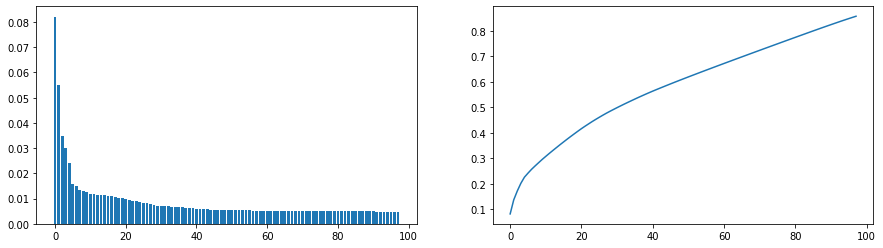

In [267]:
plot_pca(pca_half)

(781766, 100)


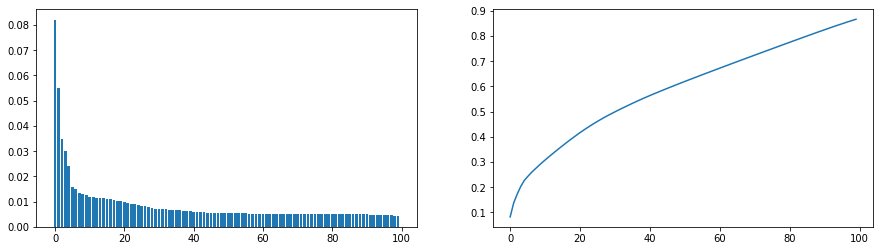

In [268]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_100 = PCA(100)
pca100_azdias = pca_100.fit_transform(azdias_copy_scaled)
print(pca100_azdias.shape)
plot_pca(pca_100)

In [269]:
100 / azdias_copy_scaled.shape[1]

0.5076142131979695

### Discussion 2.2: Perform Dimensionality Reduction

- As i noticed with half of the features which is `98` we can retain nearly ~ `83%` explained variance, 
- However i chosen `100` for the number of compenents as it can explain nearly ~ `90%`.
- also the features will be reduced by `50%` from `197` to `100` features 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [270]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def comp_weigths(pca, to_compare):
    columns = azdias_copy_scaled.columns.tolist()
    df = pd.DataFrame(data=pca.components_, columns=columns)
    df = df.iloc[to_compare].sort_values(ascending=False)
    display(df)

In [271]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weigths(pca_100, 0)

LP_STATUS_GROB_1.0       0.189433
HH_EINKOMMEN_SCORE       0.180641
PLZ8_ANTG3               0.180470
Wealth                   0.179814
PLZ8_ANTG4               0.174029
PLZ8_BAUMAX              0.170466
ORTSGR_KLS9              0.153831
EWDICHTE                 0.152055
FINANZ_HAUSBAUER         0.148851
LP_STATUS_FEIN_1.0       0.127392
KBA05_ANTG4              0.127119
PLZ8_ANTG2               0.123845
KBA05_ANTG3              0.114119
ANZ_HAUSHALTE_AKTIV      0.113709
ARBEIT                   0.111868
CAMEO_DEUG_2015_9        0.110229
LP_STATUS_FEIN_2.0       0.106044
RELAT_AB                 0.105789
FINANZTYP_1              0.101369
LP_FAMILIE_FEIN_1.0      0.099436
LP_FAMILIE_GROB_1.0      0.099436
FINANZ_SPARER            0.098016
CAMEO_DEUG_2015_8        0.090423
ZABEOTYP_5               0.069568
SEMIO_PFLICHT            0.068848
GEBAEUDETYP_3.0          0.066395
SEMIO_REL                0.065247
CAMEO_DEU_2015_8A        0.061394
W_KEIT_KIND_HH           0.061143
GFK_URLAUBERTY

In [272]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weigths(pca_100, 3)

LP_LEBENSPHASE_GROB      0.239208
LP_LEBENSPHASE_FEIN      0.233093
ANZ_PERSONEN             0.213115
LP_FAMILIE_GROB_5.0      0.208061
Movement                 0.193641
GREEN_AVANTGARDE         0.193641
ORTSGR_KLS9              0.182637
EWDICHTE                 0.180434
LP_STATUS_FEIN_10.0      0.166611
LP_STATUS_GROB_5.0       0.166611
LP_FAMILIE_FEIN_10.0     0.156051
SEMIO_KAEM               0.138554
SEMIO_DOM                0.138167
ONLINE_AFFINITAET        0.130797
LP_FAMILIE_FEIN_11.0     0.110590
PLZ8_ANTG3               0.110168
ANREDE_KZ                0.108946
PLZ8_ANTG4               0.107493
PLZ8_BAUMAX              0.095475
RELAT_AB                 0.088979
ZABEOTYP_2               0.083231
PLZ8_ANTG2               0.078777
ARBEIT                   0.077105
LP_FAMILIE_GROB_4.0      0.069955
CAMEO_DEUG_2015_1        0.067521
SHOPPER_TYP_3.0          0.062961
ALTER_HH                 0.062783
SEMIO_ERL                0.059863
LP_STATUS_GROB_3.0       0.058134
WOHNDAUER_2008

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- First Component:
> - `LP_STATUS_GROB_1.0` ( Social status ) low-income earners have a negative correlation with `SHOPPER_TYP_1.0` which is Shopping-stressed.
> - `PLZ8_ANTG4` and `wealth` have a positive correlation. As wealth increases PLZ8_ANTG4 increases which is number of 6-10 family houses.
- Third Component:
> - `LP_LEBENSPHASE_GROB` (which describe their life stage) has a postitive correlation with `movement`.
> - `LP_FAMILIE_FEIN_1.0` (which is a family type : single) has a negative correlation with `CAMEO_DEUG_2015` which describrs consumption-oriented middleclass

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [273]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
from sklearn.cluster import KMeans
def kmeans_score(data,n_cluster):
    kmeans = KMeans(n_clusters=n_cluster)
    model = kmeans.fit(data)
    return model.score(data)

In [274]:
scores = [] 
n_clusters = list(range(1, 11))
for cluster in n_clusters:
    scores.append(kmeans_score(pca100_azdias, cluster))

Text(0, 0.5, 'score')

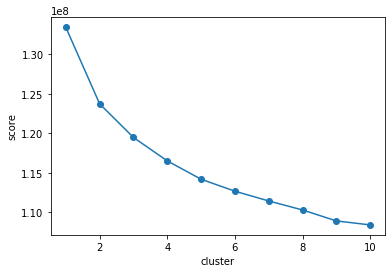

In [275]:
scores = [np.abs(score) for score in scores]
plt.plot(n_clusters, scores,marker='o')
plt.xlabel('cluster')
plt.ylabel('score')

In [276]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 9)
model_9 = kmeans.fit(pca100_azdias)
azdias_pred = model_9.predict(pca100_azdias)

### Discussion 3.1: Apply Clustering to General Population

According from the graph above the elbow moment happens with `9` clusters, therefore i have choosen to segment the data on 9 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [277]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [278]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

/Users/yasir/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [279]:
display(customers_clean.head())
print(customers_clean.shape)
# sums NA for each column then sums them all together (to avoid print more rows and table)
print((customers_clean.isna().sum()).sum()) 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Movement,Region,Wealth,life_stage
1,4.0,0,5,1,5,1,3,2,0,1.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,4.0,1,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1.0,2.0,2.0,3.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,2.0,1.0,3.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,0.0,2.0,3.0,0.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1.0,2.0,2.0,3.0


(168542, 196)
1972701


In [280]:
display(customers.GEBAEUDETYP.value_counts())
for column in azdias_copy_scaled.columns:
    if column not in customers_clean.columns.tolist():
        print(column)
        customers_clean[column] = 0 # fill with 0 (otherwise it will produce error in transformer of categorical imputer.)

1.0    83691
3.0    20879
8.0    18021
2.0     1797
4.0      227
6.0      130
Name: GEBAEUDETYP, dtype: int64

GEBAEUDETYP_5.0


In [281]:
# for column in azdias_copy_scaled.columns:
#     if column not in customers_clean.columns.tolist():
#         print(column)

In [282]:
# handle catagorical / ordinal NAN values. Same defined imputers i used for categorical and numerical attributes.
customers_clean[cat_attr] = imp_cat.transform(customers_clean[cat_attr])
customers_clean[num_attr] = imp_num.transform(customers_clean[num_attr])

In [283]:
# scaling
customers_clean_scaled = pd.DataFrame(data=scaler.transform(customers_clean), columns=customers_clean.columns)

In [284]:
display(customers_clean_scaled.head())
print(customers_clean_scaled.shape)
# sums NA for each column then sums them all together (to avoid print more rows and table)
print((customers_clean_scaled.isna().sum()).sum())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Movement,Region,Wealth,life_stage,GEBAEUDETYP_5.0
0,1.181194,-1.043578,1.413892,-1.151131,1.133968,-1.247949,0.261787,-0.816630,-0.531062,-1.638971,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,4.297099,4.265690,-1.556149,-1.248917
1,1.181194,0.958242,1.413892,-1.151131,1.133968,-1.247949,0.979224,0.612773,1.883019,-0.316577,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,11.202649,4.297099,0.508298,0.488897,-1.248917
2,1.181194,-1.043578,1.413892,-1.151131,1.133968,-0.569205,-1.173088,-0.816630,-0.531062,-0.316577,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,4.297099,-1.370397,0.488897,-1.248917
3,0.198229,-1.043578,-0.037317,-1.151131,0.407556,0.788284,1.696662,-0.816630,-0.531062,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,-0.089265,4.297099,2.386994,-1.556149,-1.248917
4,0.198229,-1.043578,1.413892,-1.151131,1.133968,-1.247949,-0.455650,-0.101929,1.883019,1.005818,...,-0.151183,-0.163742,-0.191008,-0.18126,-0.194247,11.202649,4.297099,0.508298,0.488897,-1.248917


(168542, 197)
0


In [285]:
customers_pca = pca_100.transform(customers_clean_scaled)

In [286]:
customers_pred = model_9.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [289]:
# most frequent cluster
counts = np.bincount(customers_pred)
most_fre = np.argmax(counts)
most_fre

6

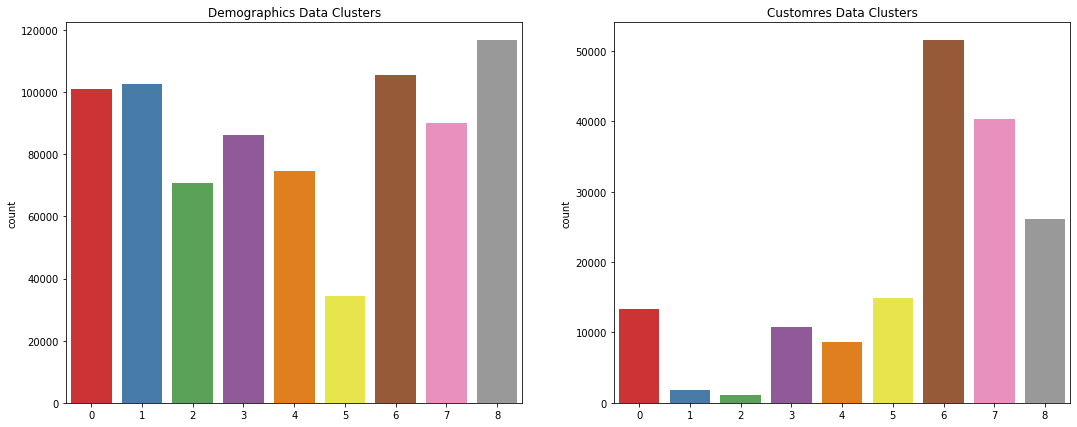

In [292]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 7))
ax1.set_title('Demographics Data Clusters')
sns.countplot(azdias_pred, ax=ax1, palette='Set1')
ax2.set_title('Customres Data Clusters')
sns.countplot(customers_pred, ax=ax2, palette='Set1')

In [291]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_100_inv = pca_100.inverse_transform(model_9.cluster_centers_[most_fre])
centroid_over_rep = scaler.inverse_transform(pca_100_inv)

In [293]:
centroid_over_rep = pd.DataFrame(data=centroid_over_rep, index=customers_clean.columns, columns=['value'])
display(centroid_over_rep.sort_values(by='value', ascending=False))

,value
MIN_GEBAEUDEJAHR,1993.113018
KBA13_ANZAHL_PKW,696.003227
LP_LEBENSPHASE_FEIN,25.151712
ALTER_HH,15.575805
WOHNDAUER_2008,8.564419
LP_LEBENSPHASE_GROB,7.309563
ORTSGR_KLS9,5.170450
SEMIO_LUST,4.982471
SEMIO_ERL,4.928364
INNENSTADT,4.759900


In [296]:
# 7 is least frequent cluster in customer clusters.
pca_100_inv = pca_100.inverse_transform(model_9.cluster_centers_[2])
centroid_under_rep = scaler.inverse_transform(pca_100_inv)

In [297]:
centroid_under_rep = pd.DataFrame(data=centroid_under_rep, index=customers_clean.columns, columns=['value'])
display(centroid_under_rep.sort_values(by='value', ascending=False))

,value
MIN_GEBAEUDEJAHR,1992.487298
KBA13_ANZAHL_PKW,551.701738
ALTER_HH,18.222059
ANZ_HAUSHALTE_AKTIV,14.176975
LP_LEBENSPHASE_FEIN,8.524086
WOHNDAUER_2008,7.018029
SEMIO_KULT,6.825596
SEMIO_FAM,6.722783
ORTSGR_KLS9,6.565334
SEMIO_SOZ,6.526200


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
- Over represented cluster is 6, the kind of people it highly represent are:
> - `KBA13_ANZAHL_PKW` : Number of cars in the PLZ8 region (where value of care in that region is: 695.826449 ~ 696 cars)
> - `LP_LEBENSPHASE_FEIN` : Life stage (where it has value of: 24.499322) which indicate to low-income earner families
> - `ALTER_HH` : Birthdate of head of household (where value is : 15 which indicate birth between  1965-01-01 to 1969-12-31)

- Under represented cluster is 2, the kind of people it highly represent are:
> - `KBA13_ANZAHL_PKW` : Number of cars in the PLZ8 region (where value of care in that region is: 541.145511 ~ 541 cars)
> - `LP_LEBENSPHASE_FEIN` : Life stage (where it has value of: 8.659157 which indicate to single average earners at retirement age
> - `ALTER_HH` : Birthdate of head of household (where value is : 18.162008 ~ 18  which indicate birth between  1980-01-01 to 1984-12-31)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.